# 📉 Filtrado de señales con la herramienta GUI pyfda

Este es un archivo en el cual se indican los pasos seguidos durante todo el proceso de filtrado de las señales empleadas. 
En esta ocasión se utilizará de ejemplo la primera derivada de la señal ECG obtenida en el laboratorio 4. 

## 📚 1. Importación de librerías
---
Se importan las librerías necesarias para la manipulación de datos, procesamiento de señales y visualización:

- pandas: para lectura y manejo de archivos de datos.
- numpy: para operaciones numéricas.
- matplotlib.pyplot: para visualización de gráficos.
- scipy.signal: para filtrado digital.

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd, csv
from scipy.signal import butter, filtfilt, iirnotch
from scipy.signal import firwin, lfilter

## 🔀 2. Lectura y extracción de datos ECG
---
Se importa la señal registrada desde un archivo de texto, extrayendo únicamente el canal de interés (A2).
Se definen además los parámetros necesario para su análisis, como frecuencia de muestro y tiempo de análisis. 

In [38]:

# ==== 1. Archivo y parámetros ECG ====
ruta1 = r"C:\Users\Garcia\Desktop\SeñalesLab6\PrimeraDerivada.txt"
Fs = 1000      
t_i = 1        
t_f = 6       

# ==== 2. Lectura del archivo ECG ====
df = pd.read_csv(
    ruta1,
    sep=r"\s+|\t+",
    engine="python",
    header=None,
    comment="#"
)

df.columns = ["nSeq", "I1", "I2", "O1", "O2", "A2"]

# ==== 3. Extracción datos ECG ====
ecg = df["A2"].to_numpy(dtype=float)


## 📈 3. Filtrado de la señal
---
La señal es procesada por medio de un filtro notch de 60 Hz y un filtro pasabanda entre 0.5 y 40 Hz. De esa manera,
se mejora la calidad de la señal.

In [39]:
# ==== 4. Filtrado: notch 60 Hz + filtro pasabanda 0.5–40 Hz ====
# Notch de 60 Hz
f0 = 60.0
Q = 30
b_notch, a_notch = iirnotch(f0/(Fs/2), Q)
ecg_notch = filtfilt(b_notch, a_notch, ecg)

# Filtro pasabanda 0.5–40 Hz 
f1, f2 = 0.5, 40.0
b_bp, a_bp = butter(4, [f1/(Fs/2), f2/(Fs/2)], btype="band")
ecg_filt = filtfilt(b_bp, a_bp, ecg_notch)

## ⏱️ 4. Creación del vector tiempo y ploteo de la señal
---
Se genera un vector de referencia para representar los momentos en donde las muestras han sido captadas, y así arma una gráfica respecto a ello. 

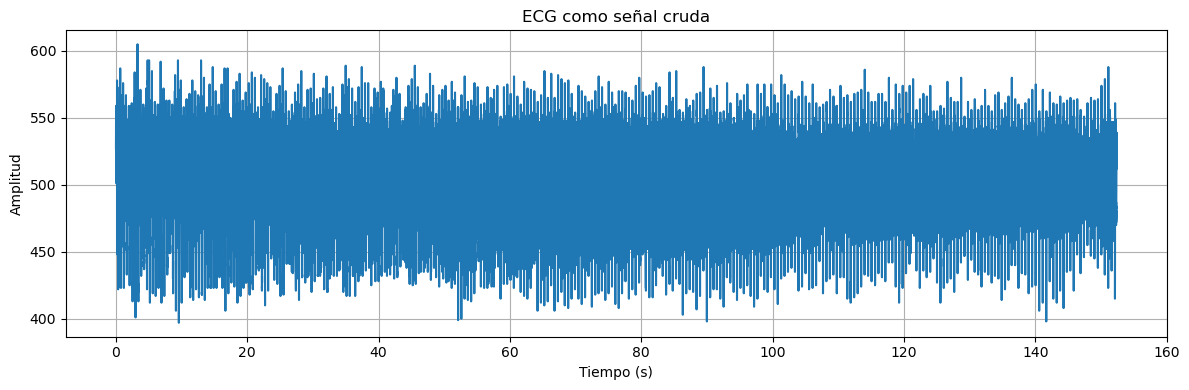

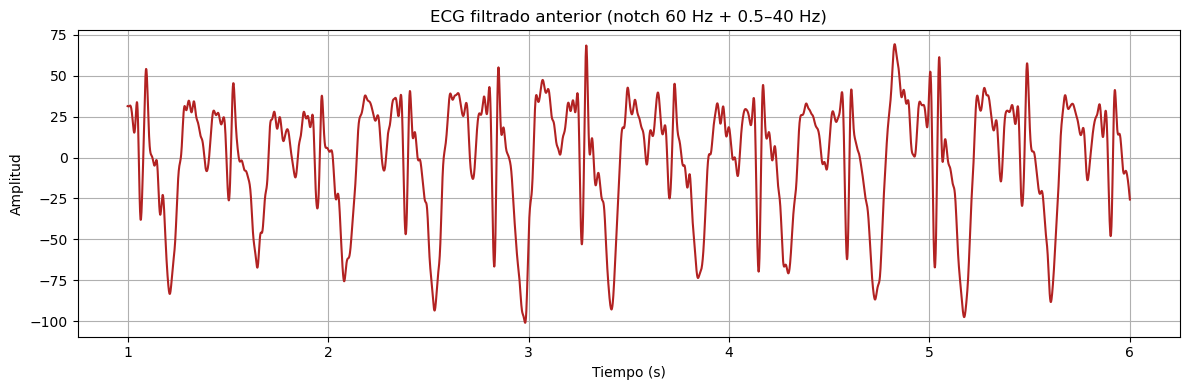

In [ ]:
# ==== 5. Creación de vector tiempo y máscara ====
t = np.arange(len(ecg)) / Fs
mask = (t >= t_i) & (t <= t_f)
# ==== 6. Ploteo de señales ====
# Señal cruda 
plt.figure(figsize=(12,4))
plt.plot(t, ecg)
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("ECG como señal cruda")
plt.grid(True)
plt.tight_layout()
plt.show()
# Señal de filtrado anterior (notch 60 Hz + 0.5-40 Hz)
plt.figure(figsize=(12,4))
plt.plot(t[mask], ecg_filt[mask], color='firebrick')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("ECG filtrado anterior (notch 60 Hz + 0.5–40 Hz)")
plt.grid(True)
plt.tight_layout()
plt.show()


## 🔊 6. Creación de función para cálculo SNR
---
Se crea función para calcular la relación señal y ruido (SNR) como complemento al análisis de filtros. 

In [41]:
# ==== EXTRA:  FUNCIÓN PARA CÁLCULO SNR ====
def snr_ecg_fft(x, fs):
    x = np.asarray(x)
    x = x - np.mean(x)                 # quita DC
    w = np.hanning(len(x))             # reduce leakage
    X = np.fft.rfft(x * w)
    freqs = np.fft.rfftfreq(len(x), 1/fs)

    idx_sig = (freqs >= 0.5) & (freqs <= 40)

    P_sig = np.sum(np.abs(X[idx_sig])**2)
    P_noise = np.sum(np.abs(X[~idx_sig])**2) + 1e-12  # evita división por 0
    return 10*np.log10(P_sig / P_noise)


## 📊 7. Creación de sistemas con filtros y su representación en gráficas
---
Se generan las gráficas obtenidas por el uso de 4 filtros de distinto tipo para el análisis de su eficiencia y efectos en la señal.

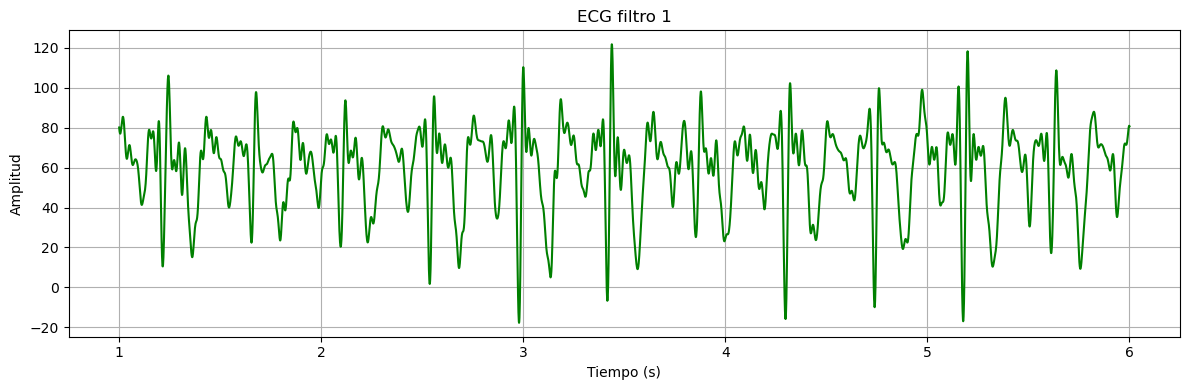

SNR ECG 1: 26.73 dB


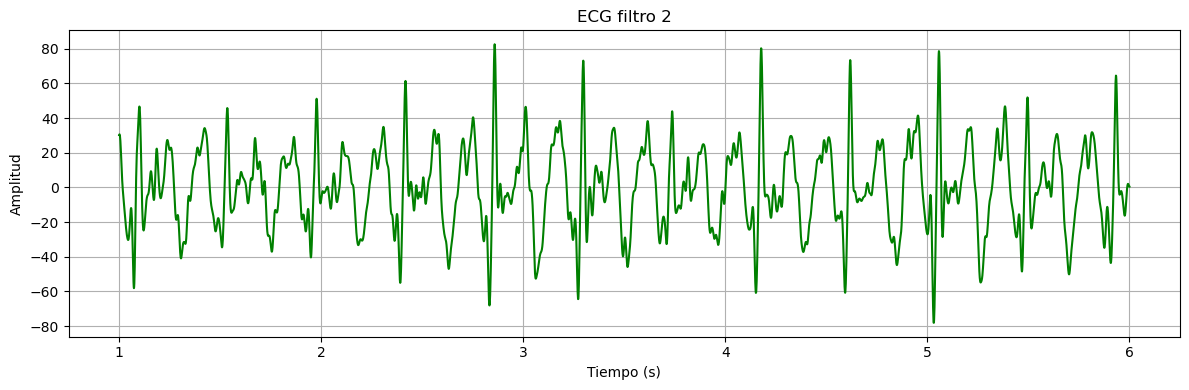

SNR ECG 2: 21.31 dB


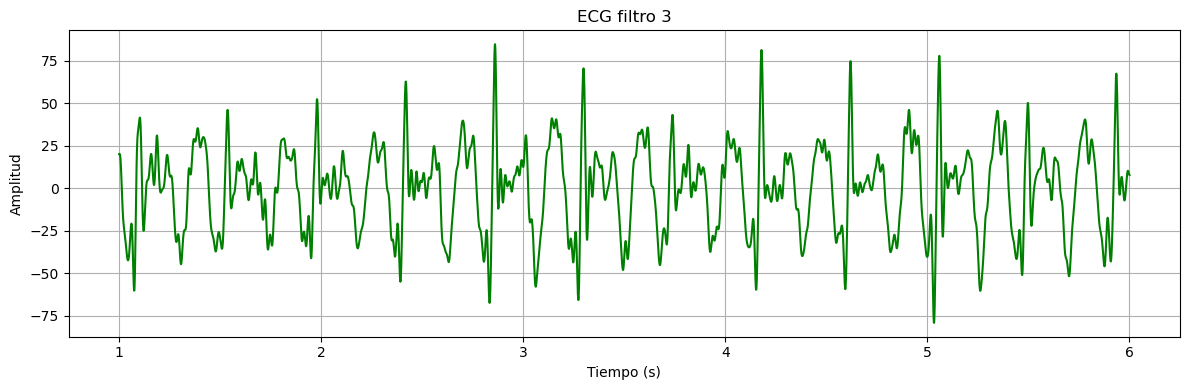

SNR ECG 3: 19.88 dB


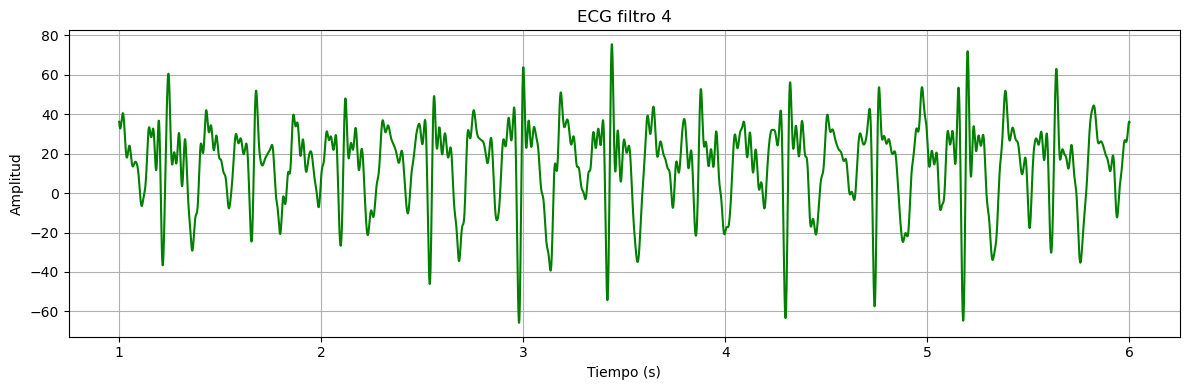

SNR ECG 4: 27.03 dB


In [ ]:
# ********** FILTRO 1 ************

path = r"C:\Users\Garcia\Desktop\Filtros\Blackman_ECG1.csv"

# ==== A. Se extraen los coeficientes a y b del filtro ====
df_1 = pd.read_csv(path, header=0)
b_1 = df_1['b'].to_numpy(dtype=float)
# Denominador es 1
a_1 = np.array([1.0], dtype=float)

# ==== B. Filtrado ====
y_1 = lfilter(b_1, a_1, ecg)

# ==== C. Ploteo de señal filtrada ====
plt.figure(figsize=(12,4))
plt.plot(t[mask], y_1[mask], color='green')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("ECG filtro 1")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== D. Cálculo del SNR ====
snr = snr_ecg_fft(y_1, Fs)
print(f"SNR ECG 1: {snr:.2f} dB")



# ********** FILTRO 2 ************

path = r"C:\Users\Garcia\Desktop\Filtros\Butterworth_ECG1.csv"

# ==== A. Se extraen los coeficientes a y b del filtro ====
df_2 = pd.read_csv(path, header=0) 
b_2 = df_2['b'].to_numpy(dtype=float)
a_2 = df_2['a'].to_numpy(dtype=float)

# ==== B. Filtrado ====
y_2 = lfilter(b_2, a_2, ecg)

# ==== C. Ploteo de señal filtrada ====
plt.figure(figsize=(12,4))
plt.plot(t[mask], y_2[mask], color='green')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("ECG filtro 2")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== D. Cálculo del SNR ====
snr = snr_ecg_fft(y_2, Fs)
print(f"SNR ECG 2: {snr:.2f} dB")

# ********** FILTRO 3 ************

path = r"C:\Users\Garcia\Desktop\Filtros\Chebyshev_ECG1.csv"

# ==== A. Se extraen los coeficientes a y b del filtro ====
df_3 = pd.read_csv(path, header=0) 
b_3 = df_3['b'].to_numpy(dtype=float)
a_3 = df_3['a'].to_numpy(dtype=float)

# ==== B. Filtrado ====
y_3 = lfilter(b_3, a_3, ecg)

# ==== C. Ploteo de señal filtrada ====
plt.figure(figsize=(12,4))
plt.plot(t[mask], y_3[mask], color='green')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("ECG filtro 3")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== D. Cálculo del SNR ====
snr = snr_ecg_fft(y_3, Fs)
print(f"SNR ECG 3: {snr:.2f} dB")

# ********** FILTRO 4 ************

path = r"C:\Users\Garcia\Desktop\Filtros\Hamming_ECG1.csv"

# ==== A. Se extraen los coeficientes a y b del filtro ====
df_4 = pd.read_csv(path, header=0) 
b_4 = df_4['b'].to_numpy(dtype=float)
# Denominador es 1
a_4 = np.array([1.0], dtype=float)

# ==== B. Filtrado ====
y_4 = lfilter(b_4, a_4, ecg)

# ==== C. Ploteo de señal filtrada ====
plt.figure(figsize=(12,4))
plt.plot(t[mask], y_4[mask], color='green')
plt.xlabel("Tiempo (s)")
plt.ylabel("Amplitud")
plt.title("ECG filtro 4")
plt.grid(True)
plt.tight_layout()
plt.show()

# ==== D. Cálculo del SNR ====
snr = snr_ecg_fft(y_4, Fs)
print(f"SNR ECG 4: {snr:.2f} dB")
